# Faraday Dreams Tutorial

Below you can find a tutorial that shows simulation of measurements from a ground truth Faraday depth signal. Then recovery is performed using Optimus Primal. 

This tutorial shows basic recovery of a Faraday depth signal for an observation

In [1]:
import sys
sys.path.insert(0,'..')
#put path to optimusprimal git repo
sys.path.insert(0,'../../Optimus-Primal')
import optimusprimal.prox_operators as prox_operators
import optimusprimal.linear_operators as linear_operators
import optimusprimal.primal_dual as primal_dual
import faradaydreams.measurement_operator as measurement_operator
import faradaydreams.models as models
import faradaydreams.plot_spectrum as plot_spectrum
import faradaydreams.convex_solvers as solvers
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = '16'

This next bit of code sets up the parameters for the observation. The samples in frequency $\nu$, which determine the samples in $\lambda^2$. 

In [2]:
c = 299792458 #speed of light m/s
m_size = 128 #numbr of channels
ISNR = 30. #signal to noise ratio of input noise
freq0 =  np.linspace(1.3e3, 9.7e3, m_size) * 10**6 # frequency coverage
dfreq = np.abs(freq0[1] - freq0[0]) # channel width
lambda2 = (c/freq0)**2 #wavelength^2 coverage
lambda1 = np.sqrt(lambda2) # wavelength coverage
dlambda2 = (c/(freq0 - dfreq/2.))**2 - (c/(freq0 + dfreq/2.))**2 * 0. + 0 #channel width in wavelength squared.
phi_max, phi_min, dphi = measurement_operator.phi_parameters(lambda2, dlambda2) #sensitivity estiamtes given coverage
dphi=25
print(dphi)
phi = np.arange(-200, 200) * dphi # range in rad/m^2 to do reconstruction of signal
weights = np.ones(m_size) #choosing flat noise
rm_max = 100#np.min([500, phi_max]) #only for plotting

2021-09-08 22:01:05,667 - Faraday Dreams - INFO - φ resolution 29.536917895865994 rad/m^2.
2021-09-08 22:01:05,668 - Faraday Dreams - INFO - φ max range is 1039.7661241894507 rad/m^2.
2021-09-08 22:01:05,669 - Faraday Dreams - INFO - φ min range is 17.859250975052067 rad/m^2.
25


### Constructing the model
Below we construct a ground truth Faraday Depth, this can be delta functions, box functions, or gaussian functions.

In [3]:
x_true = np.zeros(phi.shape, dtype=complex) * 0j #zero model of signal

We can assume the structure for Stokes I is determined by single electron population Synchrotron spectrum with $\alpha = \frac{\delta - 1}{2}$ with $\nu^{-\alpha}$
\begin{equation}
    I(\nu) = (\nu/\nu_1)^{5/2}\left [ 1 - {\rm e}^{-(\nu/\nu_1)^{(\delta + 4)/2}} \right] I_0\, .
\end{equation}
This structure has a power law with a slope of 5/2 for $\nu$ much less than $\nu_1$ and has a power law with spectra index $\alpha = (1 - \delta)/2$ when $\nu$ is much greater than $\nu_1$. Note that his model assumes a single electron population. We can perform a change of variables to $\lambda^2$ to get the equivalent equation
\begin{equation}
    I(\lambda^2) = (\lambda^2/\lambda^2_1)^{-5/4}\left [ 1 - {\rm e}^{-(\lambda^2/\lambda^2_1)^{-(\delta + 4)/4}} \right] I_0\, .
\end{equation}
At small wavelengths squared we have a power law with slope $\beta = -(1 - \delta)/4$ and at large wavelengths squared we have a power law with slope $-5/4$.

In [4]:
alpha = -0.8
delta = (-2 * alpha + 1)
#nu = 5000
nu = 2000
#nu = 800
nus = [5000, 2000, 800, 2000]
rms = [0, 0, 0, 100]
spectra2 = lambda x: np.real((x/lambda2_0)**(-5/4) * (1 - np.exp(-(x/lambda2_0)**((delta + 4)/2))))
spectra3 = lambda x: np.sin(2 * np.pi/2. * x)
#choose basis for enforce sparisty (dirac seems to be the best choice, but it depends on wavelength coverage!)
#wav = ["db2", "db4", "db6", "db8"]
#wav = ["db8", "db6", "db4"]
wav = ["dirac"]
levels = 1 #wavelet levels, makes no difference for dirac

### Constructing the measurement matrix
The measurement process can be written in the measurement equation
$$P(\lambda^2) = \int P(\phi) {\rm e}^{2 i \lambda^2 \phi}\Delta \phi \, ,$$
which maps Faraday Depth $\phi$ to the measured wavelength $\lambda^2$ for $P = Q +iU$.
The measurement matrix is determined by the following sum: 
$$P(\lambda^2_p) = \sum_{k=0}^N P(\phi_k){\rm e}^{2 i \lambda^2_p \phi_k}\Delta \phi_k$$
where $P$ is the complex polarization signal. It is a Fourier series between $\lambda^2$ and $\phi$.

We can write this as $$\mathbf{y} = \mathbf{\mathsf{\Phi}}\mathbf{x}$$ since it is a system of linear equations.

In [5]:
# measurement operator
m_op_right = measurement_operator.faraday_operator(lambda2, phi, weights)
#make more to test different types
m_op = m_op_right

Below we also create a version for comparing a noise free and better sampling instrument

In [6]:
# measurement operator without channel averaging
lambda2_high_res = np.linspace(-np.max(lambda2) * 1, np.max(lambda2), 2048) #ensure even spacing in lambda^2
m_op_high_res = measurement_operator.faraday_operator(lambda2_high_res, phi, lambda2_high_res * 0 + 1)

We calculate our simulated measurements $y$ with added noise.

2021-09-08 22:39:51,787 - Optimus Primal - INFO - Starting Power method
2021-09-08 22:39:51,788 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2021-09-08 22:39:51,789 - Optimus Primal - INFO - [Power Method] iter = 11, tol = 0.0
2021-09-08 22:39:51,790 - Optimus Primal - INFO - [Power Method] Converged with norm= 6824.970691355743, iter = 14, tol = 7.079035935505826e-05
2021-09-08 22:39:51,790 - Faraday Dreams - INFO - Using wavelets ['dirac'] with 1 levels
2021-09-08 22:39:51,791 - Faraday Dreams - INFO - Using an estimated noise level of 3.169906238768496 (weighted image units, i.e. Jy/Beam)
2021-09-08 22:39:51,792 - Faraday Dreams - INFO - Reconstructing Faraday Depth using constrained l1 regularization
2021-09-08 22:39:51,793 - Optimus Primal - INFO - Running Forward Backward Primal Dual
2021-09-08 22:39:51,795 - Optimus Primal - INFO - [Primal Dual] 0 out of 50000 iterations, tol = 0.000000
2021-09-08 22:39:52,121 - Optimus Primal - INFO - [Primal Dual] 1000 out of 5

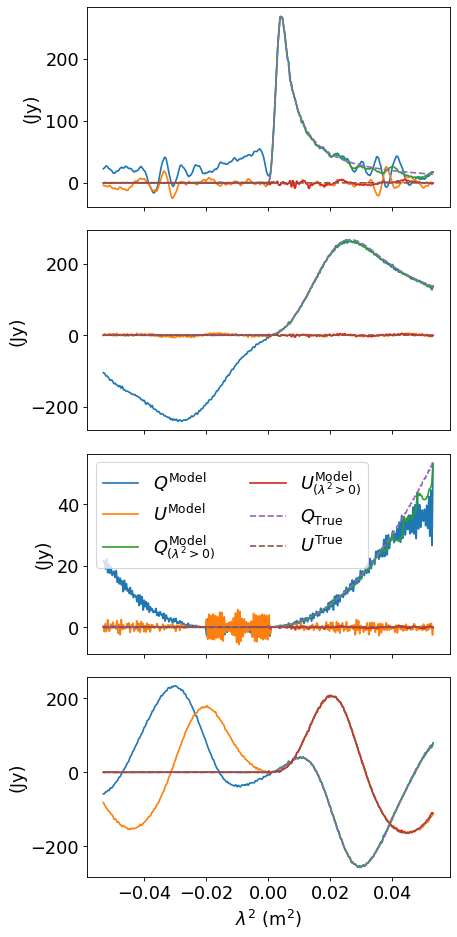

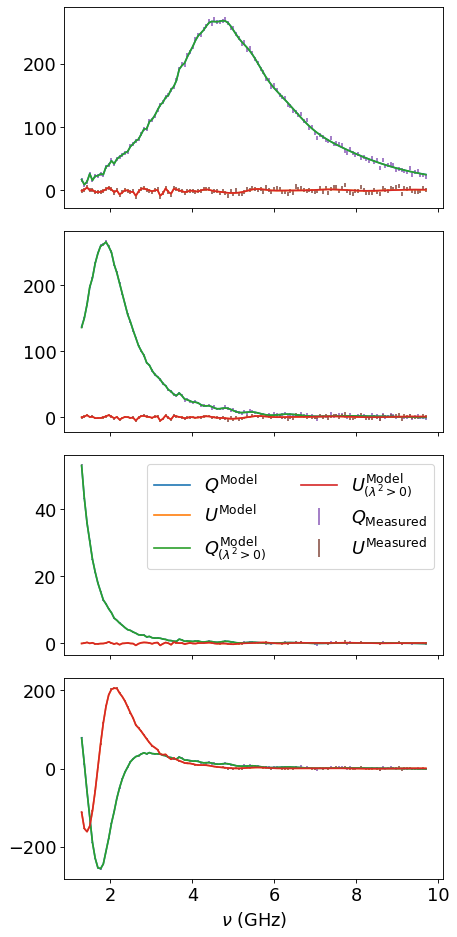

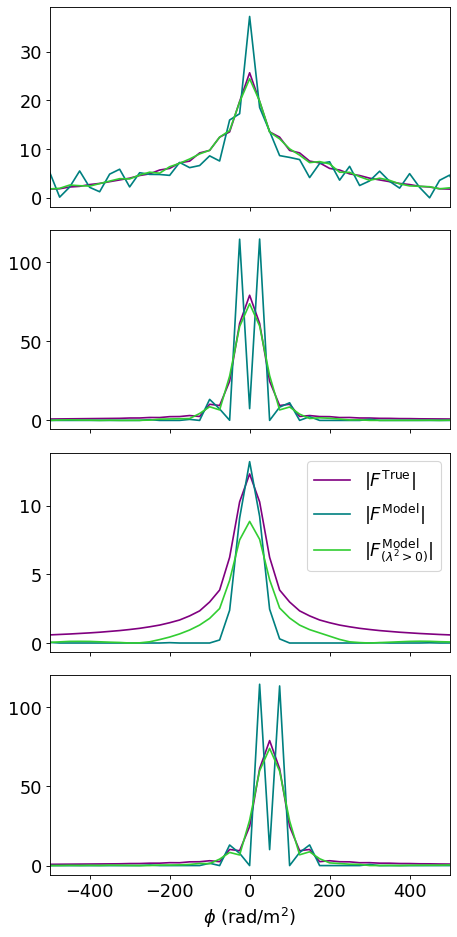

In [22]:
fig1, ax1 = plt.subplots(nrows=4, ncols=1, figsize=(6, 12), dpi=80, sharex=True)
fig2, ax2 = plt.subplots(nrows=4, ncols=1, figsize=(6, 12), dpi=80, sharex=True)
fig3, ax3 = plt.subplots(nrows=4, ncols=1, figsize=(6, 12), dpi=80, sharex=True)
rmse_p = np.zeros((len(rms)))
rmse_n = np.zeros((len(rms)))
for k in range(len(rms)):
    # simulate measurement process
    lambda2_0 = (c/nus[k] * 1e-6)**2
    spectra1 = lambda x: np.real((x/lambda2_0)**(-5/4) * (1 - np.exp(-(x/lambda2_0)**((delta + 4)/2))))
    x_true = models.from_fft_lambda2(lambda x: spectra1(x) * np.exp(1j * x * rms[k]), phi, 0)# + models.from_fft_lambda2(lambda x: spectra2(x) * np.exp(2j * x * -40), phi, 0) * 0.1
    y0 = m_op_right.dir_op(x_true)
    # add iid noise to measurements
    sigma = 10**(-ISNR/20.) * np.sqrt(np.mean(np.abs(y0)**2)/2.)
    np.random.seed(64)
    y = (y0 + np.random.normal(0, sigma, m_size) + 1j * np.random.normal(0, sigma, m_size)) * weights
    # you can choose the convergence criteria of the algorithm
    options = {'tol': 1e-5, 'iter': 50000, 'update_iter': 1000, 'record_iters': False, 'real': False, 'positivity': False, 'project_positive_lambda2': True} #algorithm properties
    beta= 1e+0 #stepsize that you might have to change 1e-2 to 1e-4 are normally okay, change if result looks bad
    #get solution of algo and run
    options['project_positive_lambda2'] = True
    nu, sol = linear_operators.power_method(m_op_right, phi* 0 + 1, 1e-4)#estimate stepsize for algo (largest eigen value of measurement matrix)
    solution_positive, diag_positive = solvers.solver(solvers.algorithm.l1_constrained, weights * y, sigma, m_op_right, wav, levels, nu, beta, options)
    #get solution of algo and run
    options['project_positive_lambda2'] = False
    solution_negative, diag_negative = solvers.solver(solvers.algorithm.l1_constrained, weights * y, sigma, m_op_right, wav, levels, nu, beta, options)
    y_positive = m_op.dir_op(solution_positive) 
    y_true = m_op_high_res.dir_op(x_true)
    y_model_positive = m_op_high_res.dir_op(solution_positive)
    y_negative = m_op.dir_op(solution_negative) 
    y_true = m_op_high_res.dir_op(x_true)
    y_model_negative = m_op_high_res.dir_op(solution_negative)
    ax1[k].plot(lambda2_high_res, np.real(y_model_negative))
    ax1[k].plot(lambda2_high_res, np.imag(y_model_negative))
    ax1[k].plot(lambda2_high_res, np.real(y_model_positive))
    ax1[k].plot(lambda2_high_res, np.imag(y_model_positive))
    ax1[k].plot(lambda2_high_res, np.real(y_true), '--')
    ax1[k].plot(lambda2_high_res, np.imag(y_true), '--')
    ax1[-1].set_xlabel(r"$\lambda^2$ (m$^2$)")
    ax1[k].set_ylabel(r"(Jy)")
    ax2[k].plot(freq0/10**9, np.real(y_negative))
    ax2[k].plot(freq0/10**9, np.imag(y_negative))
    ax2[k].plot(freq0/10**9, np.real(y_positive))
    ax2[k].plot(freq0/10**9, np.imag(y_positive))
    ax2[k].errorbar(freq0/10**9, np.real(y), yerr=lambda2*0 + sigma, fmt='',linestyle='')
    ax2[k].errorbar(freq0/10**9, np.imag(y), yerr=lambda2*0 + sigma, fmt='',linestyle='')
    ax2[-1].set_xlabel(r"$\nu$ (GHz)")
    ax3[k].plot(phi, np.abs(x_true), c="purple")
    ax3[k].plot(phi, np.abs(solution_negative), c="teal")
    ax3[k].plot(phi, np.abs(solution_positive), c="limegreen")
    ax3[-1].set_xlabel(r"$\phi$ (rad/m$^2$)")
    ax3[k].set_xlim([-500, 500])
    rmse_p[k] = np.sqrt(np.mean(np.abs(x_true - solution_positive)**2))/np.sqrt(np.mean(np.abs(x_true)**2))
    rmse_n[k] = np.sqrt(np.mean(np.abs(x_true - solution_negative)**2))/np.sqrt(np.mean(np.abs(x_true)**2))

fig1.tight_layout()
fig2.tight_layout()
fig3.tight_layout()
output_name = str(alpha) + "sync_model"
fig1.savefig(output_name + "_lambda2.pdf")
fig2.savefig(output_name + "_freq.pdf")
fig3.savefig(output_name + "_faraday.pdf")

ax1[2].legend(["$Q^{\\rm Model}$", "$U^{\\rm Model}$", "$Q^{\\rm Model}_{(\lambda^2 > 0)}$", "$U^{\\rm Model}_{(\lambda^2 > 0)}$", "$Q_{\\rm True}$", "$U^{\\rm True}$"], fontsize=16,ncol=2)
ax2[2].legend(["$Q^{\\rm Model}$", "$U^{\\rm Model}$", "$Q^{\\rm Model}_{(\lambda^2 > 0)}$", "$U^{\\rm Model}_{(\lambda^2 > 0)}$", "$Q_{\\rm Measured}$", "$U^{\\rm Measured}$"], fontsize=16,ncol=2)
ax3[2].legend([ "$|F^{\\rm True}|$", "$|F^{\\rm Model}|$", "$|F_{(\lambda^2 > 0)}^{\\rm Model}|$"], fontsize=16)

fig1.savefig(output_name + "_lambda2_label.pdf")
fig2.savefig(output_name + "_freq_label.pdf")
fig3.savefig(output_name + "_faraday_label.pdf")

In [8]:
print(rmse_p)
print(rmse_n)

[0.06464135 0.1427988  0.50200839 0.14115893]
[0.38677117 0.89058017 0.53684997 0.87423067]


You can ignore this next cell for now, but it is needed for the algorithm

Below you can choose assumptions about how to fit the true signal. You can choose wavelets or not (dirac is no wavelets). I suggest no wavelets for now

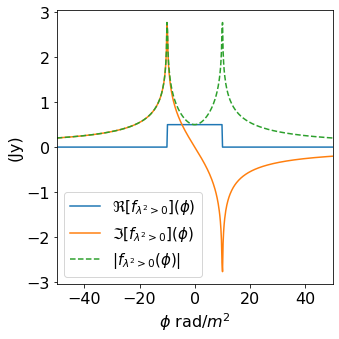

In [9]:
phi_model = np.linspace(-50,50, 512)
P = 1/(2j) * np.log(np.abs(phi_model + 10)/np.abs(phi_model - 10))
P[np.abs(phi_model) < 10] += 1/2
plt.figure(figsize=(5, 5))
plt.plot(phi_model, np.real(P))
plt.plot(phi_model, np.imag(P))
plt.plot(phi_model, np.abs(P),'--')
plt.xlim([-50, 50])
plt.legend(['$\\Re \\left[f_{\lambda^2 > 0} \\right](\\phi)$', '$\\Im \\left[f_{\lambda^2 > 0} \\right](\\phi)$', '$|f_{\lambda^2 > 0} (\\phi)|$'],fontsize=15)
plt.xlabel("$\\phi$ rad/$m^2$")
plt.ylabel("(Jy)")
plt.tight_layout()
plt.savefig("Ideal_model_box.pdf")

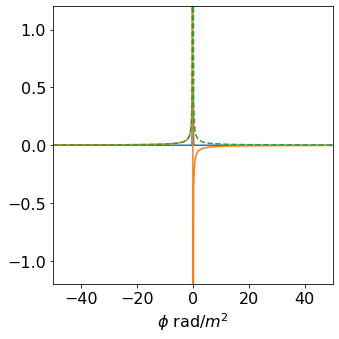

In [10]:
phi_model = np.linspace(-50,50, 512)
P = 1/(2j) * np.log(np.abs(phi_model + 0.1)/np.abs(phi_model - 0.1))
P[np.abs(phi_model) < 0.1] += 1/2
plt.figure(figsize=(5, 5))
plt.plot(phi_model, np.real(P))
plt.plot(phi_model, np.imag(P))
plt.plot(phi_model, np.abs(P),'--')
plt.xlim([-50, 50])
plt.ylim([-1.2, 1.2])
#plt.legend(['$\\Re \\left[F_{\lambda^2 > 0} \\right](\\phi)$', '$\\Im \\left[F_{\lambda^2 > 0} \\right](\\phi)$', '$|F_{\lambda^2 > 0} (\\phi)|$'],fontsize=15)
plt.xlabel("$\\phi$ rad/$m^2$")
#plt.ylabel("Jy")
plt.tight_layout()
plt.savefig("Ideal_model_delta.pdf")

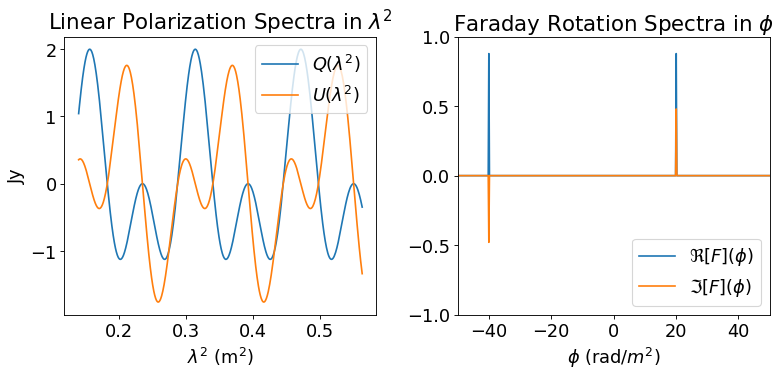

In [11]:
phi_model = np.linspace(-50,50, 512)
#P = 1/(2j) * np.log(np.abs(phi_model + 0.1)/np.abs(phi_model - 0.1))
P = phi_model * 0j
rm1 = 20
rm2 = -40
wavelength2 = (3 * 10**8/np.linspace(400, 800, 1024)/10**6)**2
P[np.abs(phi_model - rm1) < 0.1] = np.exp(2 * 0.25 * 1j)
P[np.abs(phi_model - rm2) < 0.1] = np.exp(-2 * 0.25 * 1j)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), dpi=80)
ax[1].set_title("Faraday Rotation Spectra in $\\phi$")
ax[1].plot(phi_model, np.real(P))
ax[1].plot(phi_model, np.imag(P))
ax[1].set_xlim([-50, 50])
ax[1].set_ylim([-1, 1])
ax[1].legend(['$\\Re \\left[F \\right](\\phi)$', '$\\Im \\left[F \\right](\\phi)$'])
ax[1].set_xlabel("$\\phi$ (rad/$m^2$)")
ax[0].set_ylabel("Jy")
ax[0].set_title("Linear Polarization Spectra in $\\lambda^2$")
ax[0].plot(wavelength2, np.real(np.exp(2j * rm1 * wavelength2) + np.exp(2j * rm2 * wavelength2)))
ax[0].plot(wavelength2, np.imag(np.exp(2j * rm1 * wavelength2) + np.exp(2j * rm2 * wavelength2)))
ax[0].legend(['$Q(\\lambda^2)$', '$U(\\lambda^2)$'])
ax[0].set_xlabel("$\\lambda^2$ (m$^2$)")
fig.tight_layout()

In [12]:
trials = 10
ISNRs = [10, 15, 20, 25, 30]
rmse_positive = np.zeros((len(rms), len(ISNRs), trials))
rmse_negative = np.zeros((len(rms), len(ISNRs), trials))

for i in range(len(ISNRs)):
    for k in range(len(rms)):
        for t in range(trials):
            # simulate measurement process
            lambda2_0 = (c/nus[k] * 1e-6)**2
            spectra1 = lambda x: np.real((x/lambda2_0)**(-5/4) * (1 - np.exp(-(x/lambda2_0)**((delta + 4)/2))))
            x_true = models.from_fft_lambda2(lambda x: spectra1(x) * np.exp(1j * x * rms[k]), phi, 0)# + models.from_fft_lambda2(lambda x: spectra2(x) * np.exp(2j * x * -40), phi, 0) * 0.1
            y0 = m_op_right.dir_op(x_true)
            # add iid noise to measurements
            sigma = 10**(-ISNRs[i]/20.) * np.mean(np.abs(y0))
            y = (y0 + np.random.normal(0, sigma, m_size) + 1j * np.random.normal(0, sigma, m_size)) * weights
            # you can choose the convergence criteria of the algorithm
            options = {'tol': 1e-5, 'iter': 50000, 'update_iter': 1000, 'record_iters': False, 'real': False, 'positivity': False, 'project_positive_lambda2': True} #algorithm properties
            beta= 1e-0 #stepsize that you might have to change 1e-2 to 1e-4 are normally okay, change if result looks bad
            #get solution of algo and run
            options['project_positive_lambda2'] = True
            nu, sol = linear_operators.power_method(m_op_right, phi* 0 + 1, 1e-4)#estimate stepsize for algo (largest eigen value of measurement matrix)
            solution_positive, diag_positive = solvers.solver(solvers.algorithm.l1_constrained, weights * y, sigma, m_op_right, wav, levels, nu, beta, options)
            #get solution of algo and run
            options['project_positive_lambda2'] = False
            solution_negative, diag_negative = solvers.solver(solvers.algorithm.l1_constrained, weights * y, sigma, m_op_right, wav, levels, nu, beta, options)
            y_positive = m_op.dir_op(solution_positive) 
            y_true = m_op_high_res.dir_op(x_true)
            y_model_positive = m_op_high_res.dir_op(solution_positive)
            y_negative = m_op.dir_op(solution_negative) 
            y_true = m_op_high_res.dir_op(x_true)
            y_model_negative = m_op_high_res.dir_op(solution_negative)
            rmse_positive[k, i, t] = np.sqrt(np.mean(np.abs(x_true - solution_positive)**2))/np.sqrt(np.mean(np.abs(x_true)**2))
            rmse_negative[k, i, t] = np.sqrt(np.mean(np.abs(x_true - solution_negative)**2))/np.sqrt(np.mean(np.abs(x_true)**2))

2021-06-23 20:59:19,420 - Optimus Primal - INFO - Starting Power method
2021-06-23 20:59:19,421 - Optimus Primal - INFO - [Power Method] iter = 1, tol = 0.0
2021-06-23 20:59:19,423 - Optimus Primal - INFO - [Power Method] iter = 11, tol = 0.0
2021-06-23 20:59:19,423 - Optimus Primal - INFO - [Power Method] Converged with norm= 6824.970691355743, iter = 14, tol = 7.079035935505826e-05
2021-06-23 20:59:19,424 - Faraday Dreams - INFO - Using wavelets ['dirac'] with 1 levels
2021-06-23 20:59:19,424 - Faraday Dreams - INFO - Using an estimated noise level of 37.019297134964525 (weighted image units, i.e. Jy/Beam)
2021-06-23 20:59:19,425 - Faraday Dreams - INFO - Reconstructing Faraday Depth using constrained l1 regularization
2021-06-23 20:59:19,426 - Optimus Primal - INFO - Running Forward Backward Primal Dual
2021-06-23 20:59:19,427 - Optimus Primal - INFO - [Primal Dual] 0 out of 50000 iterations, tol = 0.000000
2021-06-23 20:59:19,823 - Optimus Primal - INFO - [Primal Dual] 1000 out of 

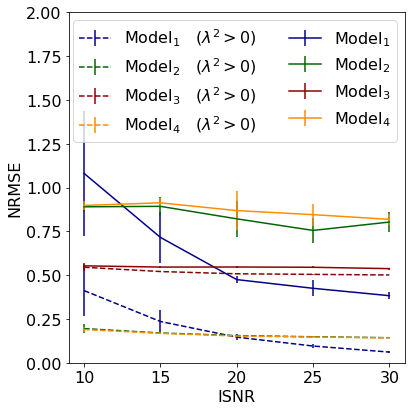

In [24]:
plt.figure(figsize=(6,6))
plt.errorbar(ISNRs,np.mean(rmse_positive[0, :, :],axis=1),yerr=np.std(rmse_positive[0, :, :],axis=1), c="darkblue", linestyle="--")
plt.errorbar(ISNRs,np.mean(rmse_positive[1, :, :],axis=1),yerr=np.std(rmse_positive[1, :, :],axis=1), c="darkgreen", linestyle="--")
plt.errorbar(ISNRs,np.mean(rmse_positive[2, :, :],axis=1),yerr=np.std(rmse_positive[2, :, :],axis=1), c="darkred", linestyle="--")
plt.errorbar(ISNRs,np.mean(rmse_positive[3, :, :],axis=1),yerr=np.std(rmse_positive[3, :, :],axis=1), c="darkorange", linestyle="--")

plt.errorbar(ISNRs,np.mean(rmse_negative[0, :, :],axis=1),yerr=np.std(rmse_negative[0, :, :],axis=1), c="darkblue")
plt.errorbar(ISNRs,np.mean(rmse_negative[1, :, :],axis=1),yerr=np.std(rmse_negative[1, :, :],axis=1), c="darkgreen")
plt.errorbar(ISNRs,np.mean(rmse_negative[2, :, :],axis=1),yerr=np.std(rmse_negative[2, :, :],axis=1), c="darkred")
plt.errorbar(ISNRs,np.mean(rmse_negative[3, :, :],axis=1),yerr=np.std(rmse_negative[3, :, :],axis=1), c="darkorange")

plt.ylim([0, 2.])
plt.ylabel("NRMSE")
plt.xlabel("ISNR")
plt.legend(["${\\rm Model_1}\quad {(\lambda^2 > 0)}$", "${\\rm Model_2}\quad {(\lambda^2 > 0)}$", "${\\rm Model_3}\quad {(\lambda^2 > 0)}$", "${\\rm Model_4}\quad {(\lambda^2 > 0)}$","${\\rm Model}_1$", "${\\rm Model}_2$", "${\\rm Model}_3$", "${\\rm Model}_4$"], fontsize=16,ncol=2)
plt.tight_layout()
plt.savefig("error_plot.pdf")